In [1]:
import pickle
import glob
from matplotlib import pyplot as plt
import mrcfile
import numpy as np
import cc3d

In [2]:
with mrcfile.open('output/other_map_and_masks/vol_000_fit_molmap_alpha_4068.mrc') as mrc:
    fit_molmap_alpha = mrc.data
with mrcfile.open('output/other_map_and_masks/vol_000_fit_alpha_mask.mrc') as mrc:
    alpha_mask = mrc.data
alpha_masked = fit_molmap_alpha * alpha_mask
alpha_mean = np.mean(alpha_masked[alpha_mask==1])
print(f"mean intensity for molmap alpha subunit:{alpha_mean}")

mean intensity for molmap alpha subunit:0.2752377986907959


In [3]:
with mrcfile.open('output/other_map_and_masks/vol_000_fit_molmap_beta_4068.mrc') as mrc:
    fit_molmap_beta = mrc.data
with mrcfile.open('output/beta_mask/vol_000_fit_beta_mask.mrc') as mrc:
    beta_mask = mrc.data
beta_masked = fit_molmap_beta * beta_mask
beta_mean = np.mean(beta_masked[beta_mask==1])
print(f"mean intensity for molmap beta subunit:{beta_mean}")

mean intensity for molmap beta subunit:0.268975168466568


In [4]:
mask_list = glob.glob('output/beta_mask/*_mask.mrc')

In [5]:
def max_connected_vol(vol):
    labels_out, N_label = cc3d.connected_components(vol, connectivity=6, return_N=True)
    if N_label != 0:
        connected_sizes = [np.sum(vol[labels_out == (idx + 1)]) for idx in range(N_label)]
        return np.amax(connected_sizes)
    else:
        return 0

In [6]:
vol_beta_occu = []
mask_overlap = []
max_connected_overlap = []

for mask in mask_list:
    vol_num = mask.split('/')[-1].split('_')[-4]
    with mrcfile.open(f'../kmeans1000/vol_{vol_num}.mrc', permissive=True) as mrc:
        vol = mrc.data
    with mrcfile.open(mask) as mrc:
        vol_beta_mask = mrc.data
    vol_alpha = (vol * alpha_mask)[alpha_mask == 1]
    vol_beta = (vol * vol_beta_mask)[(vol_beta_mask == 1) & (alpha_mask == 0)]
    vol_beta_occu.append(np.mean(vol_beta) * alpha_mean / np.mean(vol_alpha) / beta_mean)
    mask_overlap.append(np.sum(alpha_mask * vol_beta_mask))
    max_connected_overlap.append(max_connected_vol(alpha_mask * vol_beta_mask))

/home/dx63/mambaforge/envs/bio/lib/python3.9/site-packages/mrcfile/mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


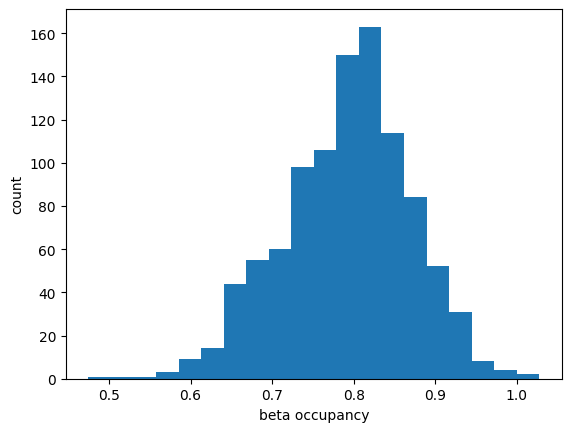

In [7]:
plt.hist(vol_beta_occu,20)
plt.xlabel('beta occupancy')
plt.ylabel('count')
plt.show()

In [8]:
# Filter by beta occupancy
occu_threshold = 0.7
low_occu = [idx for idx, tf in enumerate(np.array(vol_beta_occu) < occu_threshold) if tf == True]
low_occu_vol_idx = [int(mask_list[idx].split('/')[-1].split('_')[-4]) for idx in low_occu]
print(f"Total number of low beta occupancy clusters: {len(low_occu)}")
print(f"Cluster index of low beta occupancy clusters: {low_occu_vol_idx}")

Total number of low beta occupancy clusters: 134
Cluster index of low beta occupancy clusters: [0, 10, 21, 26, 27, 30, 32, 33, 34, 35, 36, 42, 43, 44, 45, 66, 67, 68, 69, 78, 81, 82, 90, 91, 94, 95, 96, 104, 108, 119, 120, 121, 122, 129, 159, 160, 161, 162, 173, 174, 191, 192, 193, 195, 199, 200, 201, 202, 203, 206, 208, 209, 210, 223, 224, 227, 229, 230, 231, 232, 233, 234, 236, 238, 248, 274, 277, 288, 294, 296, 297, 298, 299, 300, 302, 304, 305, 307, 310, 313, 322, 329, 330, 331, 332, 333, 335, 336, 340, 352, 357, 367, 368, 369, 371, 376, 406, 413, 433, 434, 435, 437, 444, 468, 473, 476, 477, 478, 479, 480, 486, 520, 554, 645, 651, 653, 666, 667, 757, 758, 759, 764, 766, 768, 769, 771, 774, 775, 818, 828, 829, 891, 907, 917]


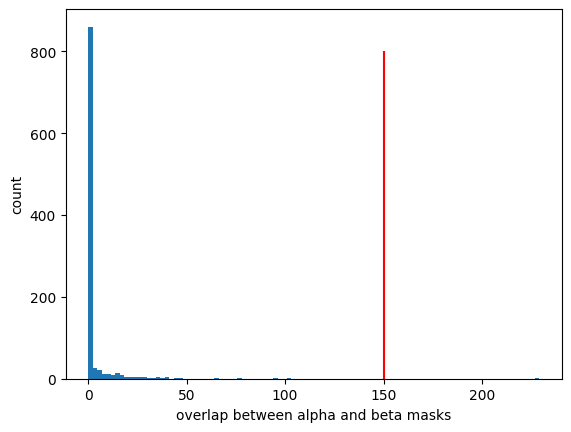

In [9]:
overlap_threshold = 150
plt.hist(mask_overlap, 100)
plt.vlines(overlap_threshold, 0, 800, color='r')
plt.xlabel('overlap between alpha and beta masks')
plt.ylabel('count')
plt.show()

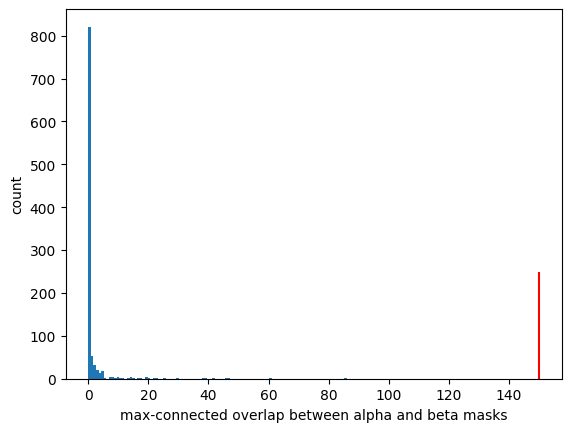

In [10]:
plt.hist(max_connected_overlap, 100)
plt.vlines(overlap_threshold, 0, 250, color='r')
plt.xlabel('max-connected overlap between alpha and beta masks')
plt.ylabel('count')
plt.show()

In [11]:
# Filter by max-connected overlap between masks
connected_overlap_large = [idx for idx, tf in enumerate(np.array(max_connected_overlap)>overlap_threshold) if tf == True]
connected_overlap_large_vol_idx = [int(mask_list[idx].split('/')[-1].split('_')[-4]) for idx in connected_overlap_large]
print(f"Total number of low beta occupancy clusters: {len(connected_overlap_large)}")
print(f"Cluster index of low beta occupancy clusters: {connected_overlap_large_vol_idx}")

Total number of low beta occupancy clusters: 0
Cluster index of low beta occupancy clusters: []


In [12]:
idx_to_keep = [idx for idx in range(len(mask_list)) if idx not in list(set((connected_overlap_large + low_occu)))]
vol_to_keep = [int(mask_list[idx].split('/')[-1].split('_')[-4]) for idx in idx_to_keep]

In [13]:
print(f"Total number of cluster volumes to keep after filtering low occupancy and large overlap: {len(vol_to_keep)}")

Total number of cluster volumes to keep after filtering low occupancy and large overlap: 866


In [14]:
# Filter with volume PCA performed by cryoDRGN
with open('../clustering_L2_average_20/state_labels.pkl', 'rb') as f:
    state_labels = pickle.load(f) # Clusters from volume PCA performed by cryoDRGN landscape analysis

In [15]:
cluster_to_remove = [11, 15, 16, 18, 19] # Manually inspected volume PCs to remove bad ones
vol_to_remove_pca = [idx for idx in range(len(state_labels)) if state_labels[idx] in cluster_to_remove]

In [16]:
vol_to_keep = [vol for vol in vol_to_keep if vol not in vol_to_remove_pca]

In [17]:
print(f"Total number of cluster volumes to keep at the end: {len(vol_to_keep)}")

Total number of cluster volumes to keep at the end: 862


In [18]:
# Save index of volumes to keep
with open('output/vol_to_keep.pkl','wb') as f:
    pickle.dump(vol_to_keep,f)

In [19]:
# Get and save partcile count for each cluster
with open('../kmeans1000/labels.pkl', 'rb') as f:
    label = pickle.load(f)

vol_ptcl_count = [np.sum(label==idx) for idx in vol_to_keep]

with open('output/turnover_vol_ptcl_count.pkl', 'wb') as f:
    pickle.dump(vol_ptcl_count,f)